In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from format_the_data import format_mi_band_data
import json

In [15]:
### set os dir to data
os.chdir('/Users/Gerard/Downloads')
andy = pd.read_csv('20231030_8210796956_MiFitness_hlth_center_fitness_data.csv')
tom = pd.read_csv('20231030_8211531339_MiFitness_hlth_center_fitness_data.csv')
huub = pd.read_csv('20231031_8210564343_MiFitness_hlth_center_fitness_data.csv')
oumaima = pd.read_csv('20231101_8210586841_MiFitness_hlth_center_fitness_data.csv')

behaviour_tracking_data = pd.read_csv('Data app - Habits.csv')

In [16]:
andy['Person'] = 'andy'
tom['Person'] = 'tom'
huub['Person'] = 'huub'
oumaima['Person'] = 'oumaima'

master_frame = pd.concat([andy, tom, huub, oumaima], ignore_index=True)

In [17]:
unique_keys = ['pai',
               'valid_stand', 
               'calories',
               'steps',
               'heart_rate',
               'intensity',
               'dynamic',
               'single_heart_rate',
               'single_spo2',
               'training_load',
               'single_stress',
               'stress',
               'watch_night_sleep',
               'resting_heart_rate',
               'watch_daytime_sleep',
               'weight']
key_dataframes = format_mi_band_data(unique_keys, master_frame)


# separate dataframes:
pai_df = key_dataframes['pai']
valid_stand_df = key_dataframes['valid_stand']
calories_df = key_dataframes['calories']
steps_df = key_dataframes['steps']
heart_rate_df = key_dataframes['heart_rate']
intensity_df = key_dataframes['intensity']
dynamic_df = key_dataframes['dynamic']
single_heart_rate_df = key_dataframes['single_heart_rate']
single_spo2_df = key_dataframes['single_spo2']
training_load_df = key_dataframes['training_load']
single_stress_df = key_dataframes['single_stress']
stress_df = key_dataframes['stress']
watch_night_sleep_df = key_dataframes['watch_night_sleep']
resting_heart_rate_df = key_dataframes['resting_heart_rate']
watch_daytime_sleep_df = key_dataframes['watch_daytime_sleep']
weight_df = key_dataframes['weight']

# Intuition

I think we need to include control variables such as the number of hours sleep and the quality of sleep as this significantly influences your mental state after awaking.

I guess we can check whether someone has slept after their alarm right?

We must include variable for smart alarm or not. Can we find this in the settings from the mi band?

We are going to add features from our watch data to the behavioural data.

Features for our analysis:
- Average of the first 20 minutes after waking
- Whether the smart alarm actually woke us up in light sleep (not in deep or REM)

Hence we need:
- Waking time
- Heartrate data
- State when awaking

In [18]:
from feature_engineering import get_wake_up_info

result = get_wake_up_info(watch_night_sleep_df, behaviour_tracking_data)
result.head()

,Name,Drinks,Fastfood,Sports,Food 2huub before sleep,Medication,Date created,Woke up by (smart) alarm,Woke up by external factors,Yesterday,Slept again after alarm,Smart alarm,Date,time_of_awakening,state_before_awakening
0,andy,False,True,True,False,False,2023-10-01T08:41:41.000Z,True,False,False,False,False,2023-10-01,05:14:00,3.0
1,andy,False,True,False,False,False,2023-10-02T07:00:32.000Z,False,False,False,False,False,2023-10-02,05:04:00,3.0
2,andy,False,False,False,False,False,2023-10-03T05:31:28.000Z,True,False,False,False,False,2023-10-03,05:32:00,3.0
3,andy,False,False,False,False,False,2023-10-04T03:12:57.000Z,True,False,False,False,False,2023-10-04,03:12:00,3.0
4,andy,False,False,False,False,False,2023-10-05T07:00:29.000Z,True,False,False,False,False,2023-10-05,06:00:00,3.0


In [25]:
# print the number of observations for each name in behaviour_tracking_data
print(behaviour_tracking_data['Name'].value_counts())
print(behaviour_tracking_data['Smart alarm'].value_counts())
# split the dataframe for smart alarm true and false
smart_alarm_true = behaviour_tracking_data[behaviour_tracking_data['Smart alarm'] == True]
smart_alarm_false = behaviour_tracking_data[behaviour_tracking_data['Smart alarm'] == False]

# print state of awakening for smart alarm true and false
print(smart_alarm_true['state_before_awakening'].value_counts())
print(smart_alarm_false['state_before_awakening'].value_counts())

Name
andy       28
tom        27
roman      26
oumaima    23
huub       15
Name: count, dtype: int64
Smart alarm
False    62
True     57
Name: count, dtype: int64
state_before_awakening
3.0    37
Name: count, dtype: int64
state_before_awakening
3.0    48
4.0     1
Name: count, dtype: int64


## Conclusie

Als we smartwake gebruiken worden we wakker in light sleep en als we een normaal alarm gebruiken ook.
Dit kan een gevolg zijn van het geval dat het smart alarm van ons horloge niet beter werkt dan normaal.
Systematic failure. -> naja we worden juist wel wakker in light sleep, dus t werkt wel.

Mochten we geen significante resultaten vinden, zou dit een oorzaak kunnen zijn.

Now we need to get save the wake time into the behavioural dataframe

### vanaf hier is vlm niet echt noodzakelijk

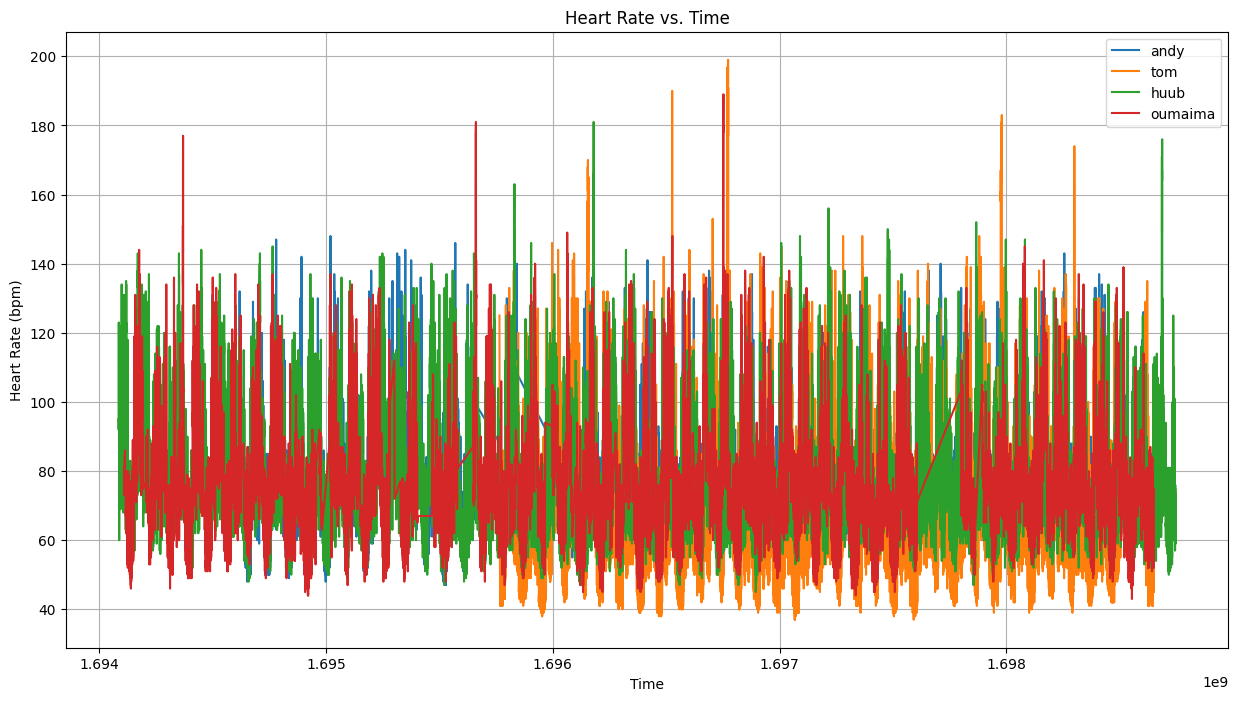

In [9]:
# Plot for all of us together
persons = heart_rate_df['Person'].unique()

plt.figure(figsize=(15, 8))

for person in persons:
    person_data = heart_rate_df[heart_rate_df['Person'] == person]
    plt.plot(person_data['Time'], person_data['bpm'], label=person)

plt.title('Heart Rate vs. Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)
plt.show()


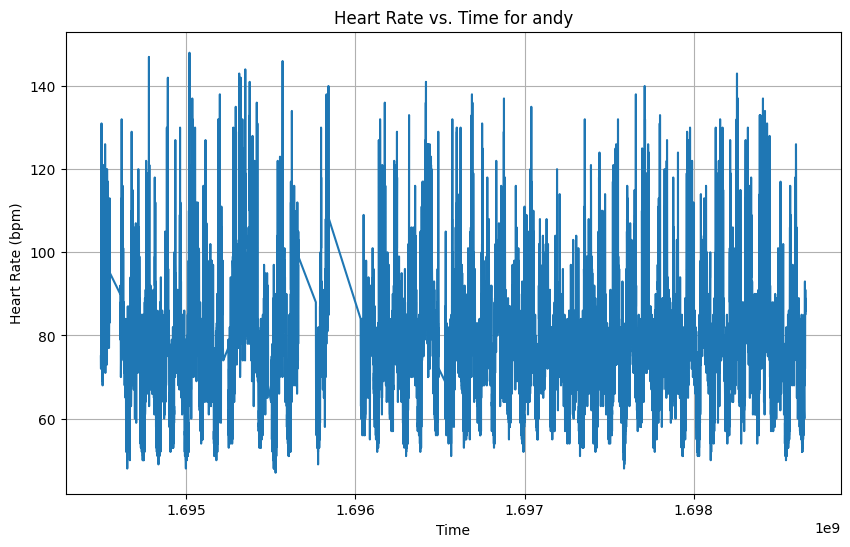

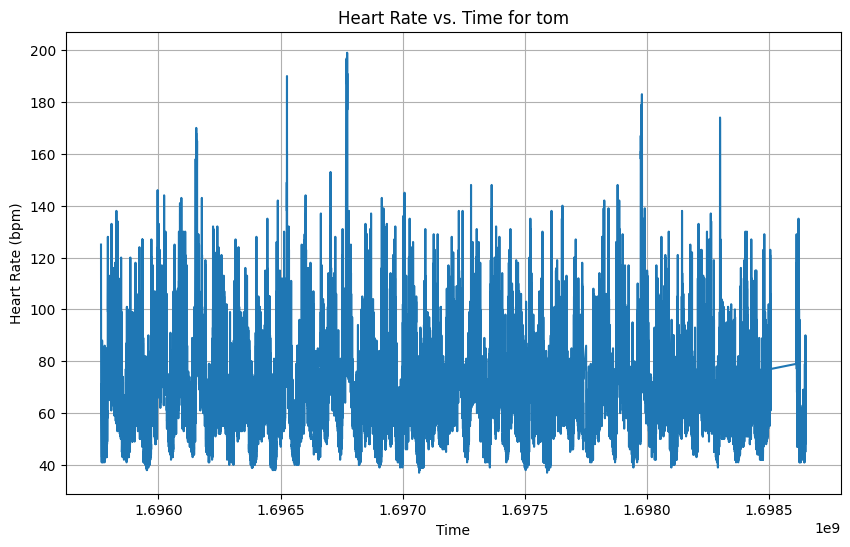

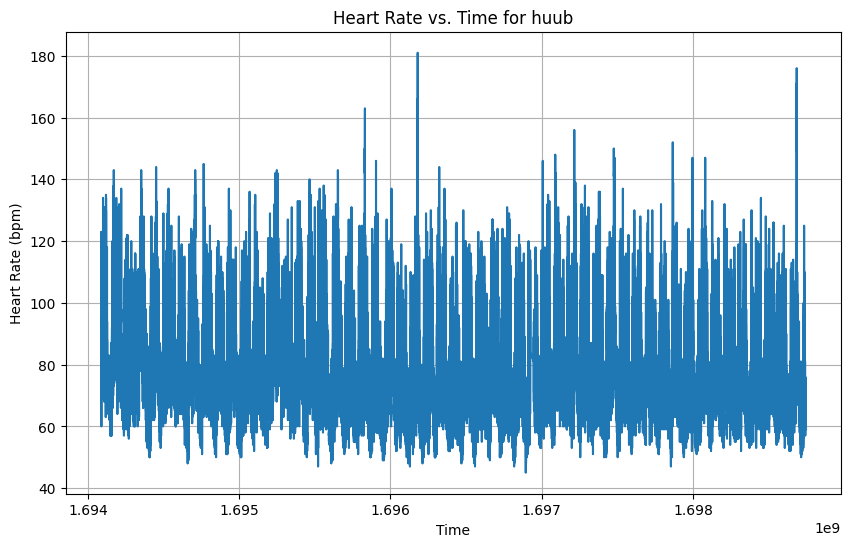

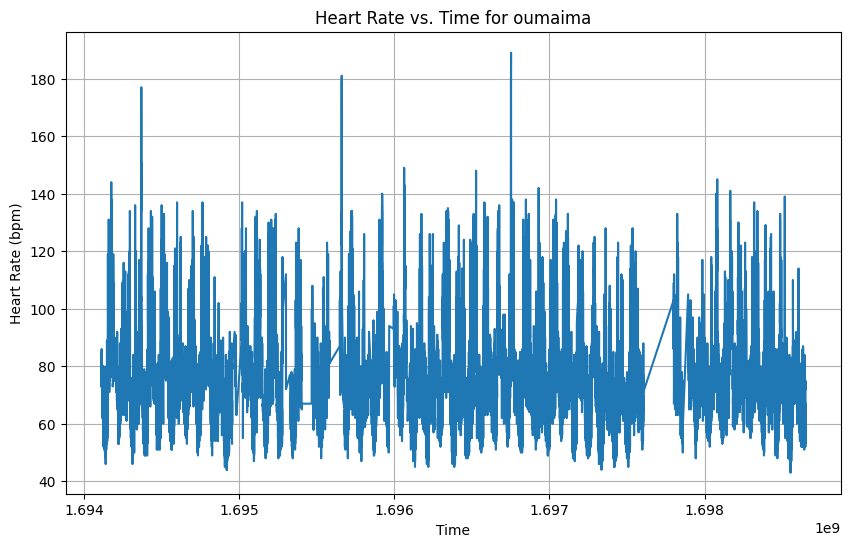

In [10]:
# Plot for each person separately
for person in persons:
    person_data = heart_rate_df[heart_rate_df['Person'] == person]
    
    plt.figure(figsize=(10, 6))
    plt.plot(person_data['Time'], person_data['bpm'])
    
    plt.title(f'Heart Rate vs. Time for {person}')
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.grid(True)
    
    plt.show()

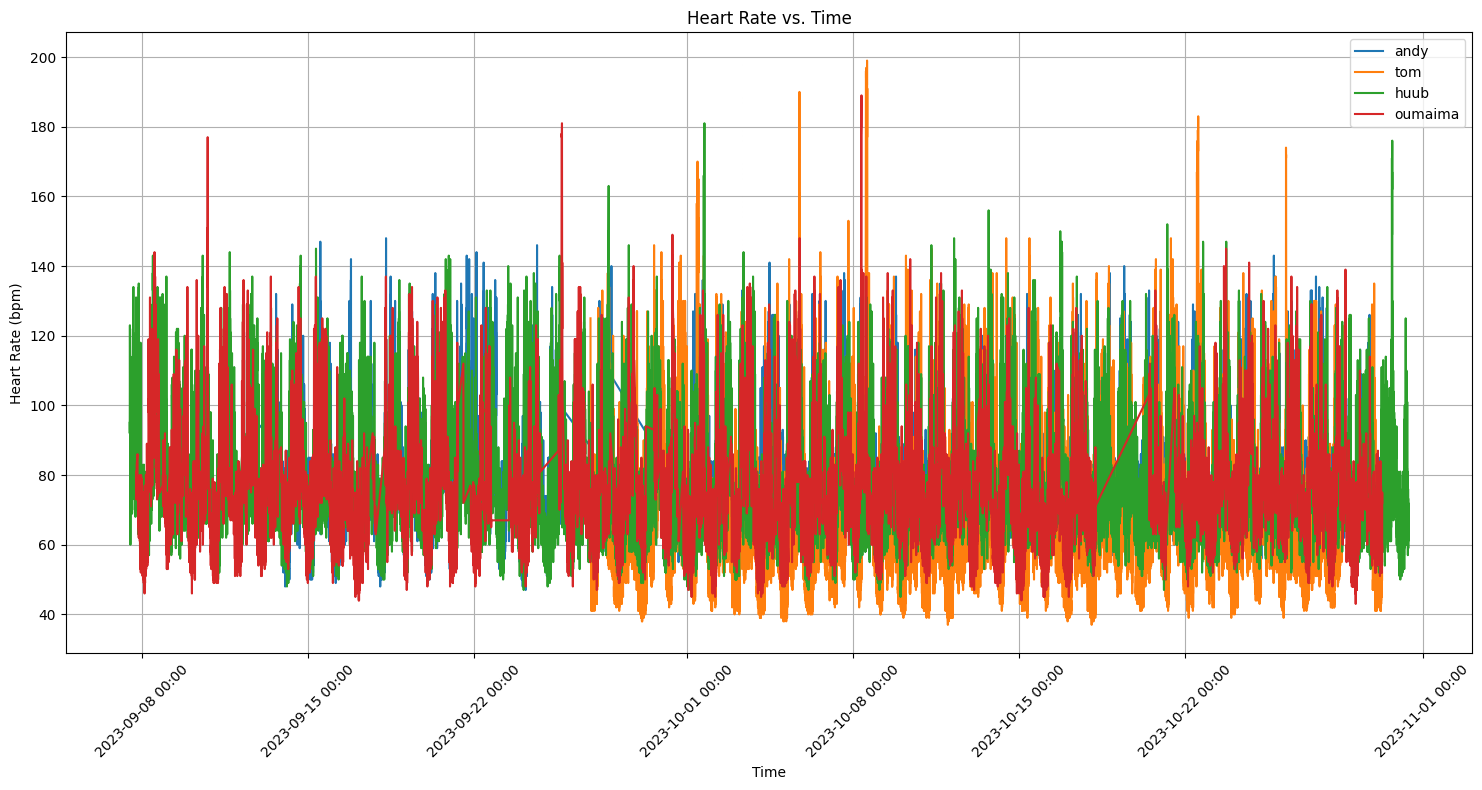

In [11]:
heart_rate_df['DateTime'] = pd.to_datetime(heart_rate_df['Time'], unit='s')
import matplotlib.dates as mdates

plt.figure(figsize=(15, 8))

# For each person, plot their data
for person in persons:
    person_data = heart_rate_df[heart_rate_df['Person'] == person]
    plt.plot(person_data['DateTime'], person_data['bpm'], label=person)

# Formatting the x-axis
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.title('Heart Rate vs. Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.tight_layout()  # To ensure labels fit
plt.legend()
plt.grid(True)
plt.show()


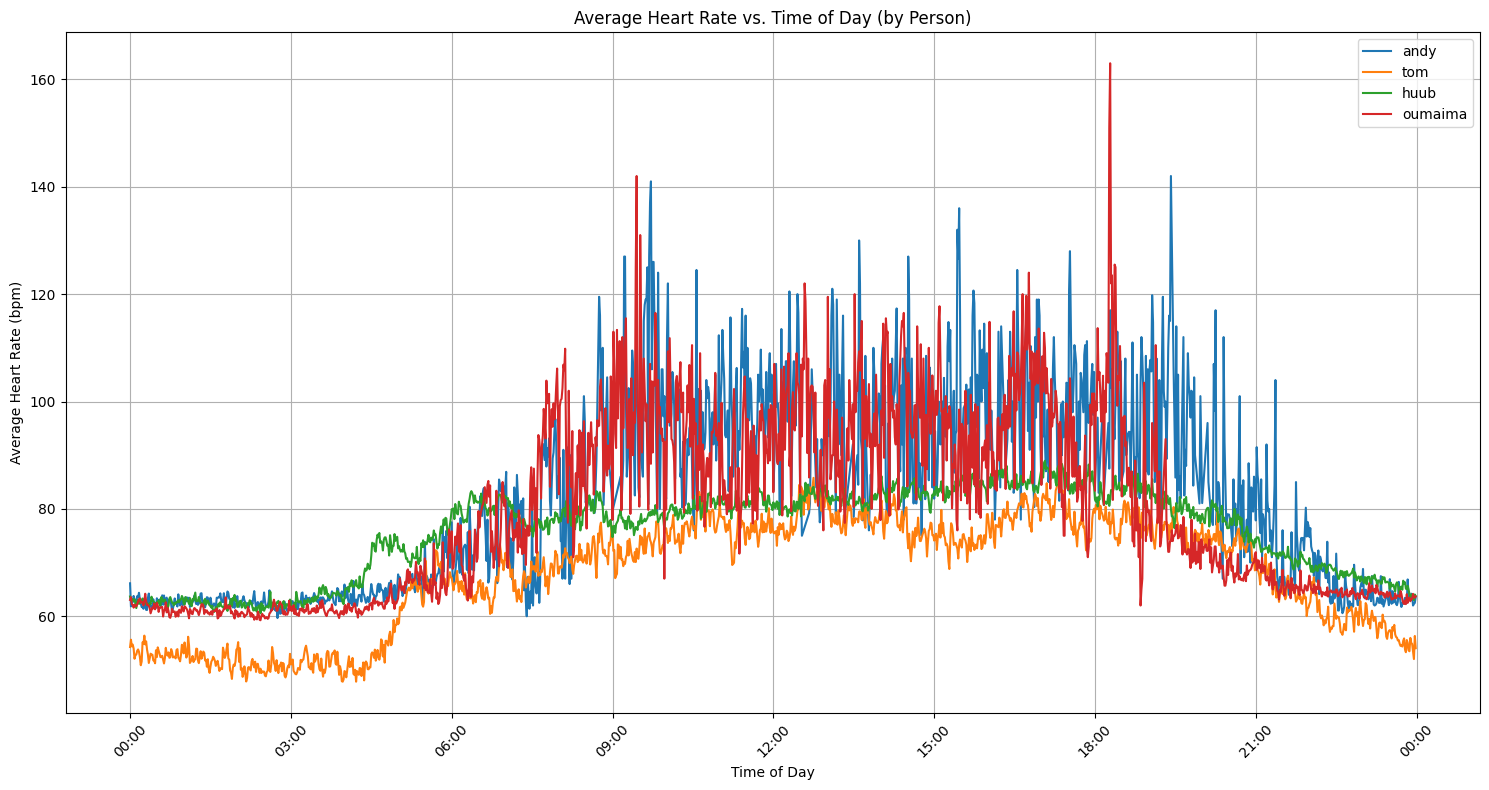

In [12]:
heart_rate_df['Hour'] = heart_rate_df['DateTime'].dt.hour
heart_rate_df['Minute'] = heart_rate_df['DateTime'].dt.minute
avg_heart_rate_per_person = heart_rate_df.groupby(['Person', 'Hour', 'Minute'])['bpm'].mean().reset_index()

avg_heart_rate_per_person['TimeOfDay'] = pd.to_datetime('2000-01-01 ' + avg_heart_rate_per_person['Hour'].astype(str) + ':' + avg_heart_rate_per_person['Minute'].astype(str))

plt.figure(figsize=(15, 8))

# For each person, plot their average heart rate
for person in persons:
    person_data = avg_heart_rate_per_person[avg_heart_rate_per_person['Person'] == person]
    plt.plot(person_data['TimeOfDay'], person_data['bpm'], label=person)

# Formatting the x-axis
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

plt.title('Average Heart Rate vs. Time of Day (by Person)')
plt.xlabel('Time of Day')
plt.ylabel('Average Heart Rate (bpm)')
plt.tight_layout()  # To ensure labels fit
plt.legend()
plt.grid(True)
plt.show()
